In [68]:
import numpy as np
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt
import time

In [12]:
polygon_files = ["perim_data/east_troublesome_ts.gpkg"]
data = gpd.read_file(polygon_files[0])
print(data.head)

<bound method NDFrame.head of             sim  id                     dates  \
0    experiment   1 2020-10-22 11:00:00+00:00   
1    experiment   2 2020-10-22 11:20:00+00:00   
2    experiment   3 2020-10-22 11:40:00+00:00   
3    experiment   4 2020-10-22 12:00:00+00:00   
4    experiment   5 2020-10-22 12:20:00+00:00   
..          ...  ..                       ...   
388        a_op   3 2020-10-24 01:30:30+00:00   
389        a_op   4 2020-10-24 13:29:52+00:00   
390        a_op   5 2020-10-24 20:37:52+00:00   
391        a_op   6 2020-10-24 22:45:47+00:00   
392        a_op   7 2020-10-25 01:29:47+00:00   

                                              geometry  
0    MULTIPOLYGON (((438538.814 4466012.402, 438538...  
1    MULTIPOLYGON (((438483.316 4466040.804, 438483...  
2    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
3    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
4    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
..                                     

In [63]:
print(data.shape)

            sim  id                     dates  \
0    experiment   1 2020-10-22 11:00:00+00:00   
1    experiment   2 2020-10-22 11:20:00+00:00   
2    experiment   3 2020-10-22 11:40:00+00:00   
3    experiment   4 2020-10-22 12:00:00+00:00   
4    experiment   5 2020-10-22 12:20:00+00:00   
..          ...  ..                       ...   
388        a_op   3 2020-10-24 01:30:30+00:00   
389        a_op   4 2020-10-24 13:29:52+00:00   
390        a_op   5 2020-10-24 20:37:52+00:00   
391        a_op   6 2020-10-24 22:45:47+00:00   
392        a_op   7 2020-10-25 01:29:47+00:00   

                                              geometry  
0    MULTIPOLYGON (((438538.814 4466012.402, 438538...  
1    MULTIPOLYGON (((438483.316 4466040.804, 438483...  
2    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
3    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
4    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
..                                                 ...  
388  MULTIPO

In [60]:
idx = 1
print(type(data.iloc[idx]["geometry"]))
print(len(data.iloc[idx]["geometry"].geoms))

print(data.iloc[idx]["geometry"].geoms[0].area)
#print(data.iloc[0]["geometry"].geoms[0].exterior)

print(len(data.iloc[idx]["geometry"].geoms[0].exterior.coords))
simple_poly = data.iloc[idx]["geometry"].geoms[0].simplify(0.05).exterior
print(len(simple_poly.coords))
print(simple_poly)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
1
411290.8838642978
2684
466
LINEARRING (438483.31583092775 4466040.803579322, 438483.31583092775 4466068.775866805, 438483.6429987677 4466068.87644709, 438483.93215309345 4466069.098323007, 438484.1225886945 4466069.409085664, 438484.189008268 4466069.767453614, 438484.189008268 4466096.652701322, 438484.34778391564 4466096.926394937, 438484.41420348914 4466097.284762886, 438484.41420348914 4466124.171255825, 438484.57644486247 4466124.449007283, 438484.64286443597 4466124.807375233, 438484.64286443597 4466151.753413578, 438512.48549620004 4466151.753413578, 438512.83285780915 4466151.298341057, 438513.42064306146 4466151.107358051, 438538.72083401156 4466151.107358051, 438539.02985100594 4466151.156301535, 438539.31463037734 4466151.302953547, 438567.1177171707 4466151.35189703, 438567.6177171707 4466151.7151682945, 438567.8087001763 4466152.302953547, 438567.8087001763 4466178.597841235, 438595.9453780828 4466178.597841235, 438596

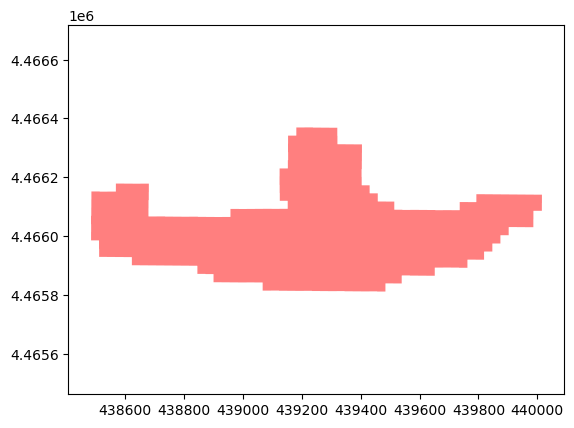

In [61]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')
xs, ys = simple_poly.xy    
axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')
plt.show()

In [87]:
### evaluate distance
def dist(a, b):
    return ((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2)

### algorithm 1 -- naive max over min distances nearest neighbors
def nn_basic(gpd_dataset, stopat):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()

    ### get original inner perimeter
    step_n_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].exterior.coords
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        if i % 10 == 0:
            print("basic", i)

        step_n_0 = step_n_1
        step_n_1 = gpd_dataset.iloc[i]["geometry"].geoms[0].exterior.coords
        step_pairs = [] ### step_n_1 point with minimum distance
        step_dists = []  ### distance to nearest step_n_1 point
        ### iterate over inner points
        for j in range(len(step_n_0)):
            rolling_closest = None
            rolling_dist = float("inf")
            ### iterate over outer points to find closest
            for k in range(len(step_n_1)):
                tdist = dist(step_n_0[j], step_n_1[k])
                if tdist < rolling_dist:
                    rolling_dist = tdist
                    rolling_closest = k
            step_pairs.append(rolling_closest)
            step_dists.append(rolling_dist)

        step_orig = np.argmax([step_dists])
        step_max = step_dists[step_orig]
        step_dest = step_pairs[step_orig]
        #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([step_orig, step_dest])
        result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [88]:
### algorithm 2 -- naive min/max knn with simplified geometries
def nn_simplified(gpd_dataset, stopat):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()
    
    ### get original inner perimeter and simplify geometry with tolerance 0.05
    step_n_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].simplify(0.05).exterior.coords
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        if i % 10 == 0:
            print("simplified", i)

        ### move outer geometry to inner geometry
        step_n_0 = step_n_1
        ### get next outer geometry and simplify with tolerance 0.05
        step_n_1 = gpd_dataset.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.coords
        step_pairs = [] ### step_n_1 point with minimum distance
        step_dists = []  ### distance to nearest step_n_1 point
        ### iterate over inner points
        for j in range(len(step_n_0)):
            rolling_closest = None
            rolling_dist = float("inf")
            ### iterate over outer points to find closest
            for k in range(len(step_n_1)):
                tdist = dist(step_n_0[j], step_n_1[k])
                if tdist < rolling_dist:
                    rolling_dist = tdist
                    rolling_closest = k
            step_pairs.append(rolling_closest)
            step_dists.append(rolling_dist)

        step_orig = np.argmax([step_dists])
        step_max = step_dists[step_orig]
        step_dest = step_pairs[step_orig]
        #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([step_orig, step_dest])
        result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [93]:
stopat = 40
### compare methods
print("comparing basic")
#nnb_res = nn_basic(data, stopat)
print("comparing simplified basic")
nns_res = nn_simplified(data, stopat)

comparing basic
comparing simplified basic
simplified 10
simplified 20


ValueError: x and y must have same first dimension, but have shapes (9,) and (392,)

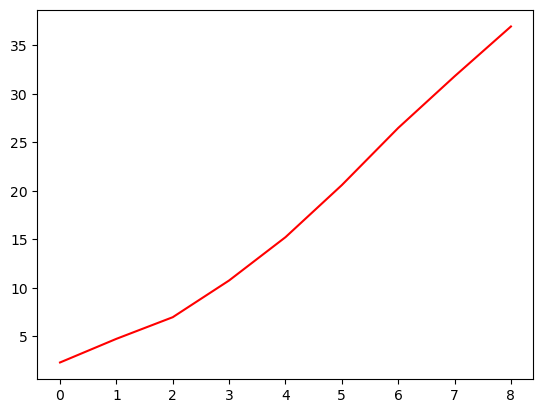

In [92]:
### step one -- compare times...
fig, axs = plt.subplots()
itersteps = np.arange(len(nnb_res[2]))
#axs.plot(itersteps, nnb_res[2], color="red", label="basic")
axs.plot(itersteps, nns_res[2], color="green", label="simplified")
axs.legend()

plt.show()